Train model on given data

## Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.ensemble import IsolationForest
from kneed import KneeLocator
import random
import os
import json
from sklearn.neighbors import NearestNeighbors

In [2]:
current_dir = os.getcwd()
current_dir

'd:\\E\\Study\\Projects\\basicml\\scripts\\training'

In [3]:
input_file=os.path.abspath(current_dir+"../../../data/training/data.csv")
training_logs_file=os.path.abspath(current_dir+"../../../data/training/training_logs.json")
training_data_path=os.path.abspath(current_dir+"../../../data/training/")
plots_path=os.path.abspath(current_dir+"../../../plots/")

## Generate Data and Save

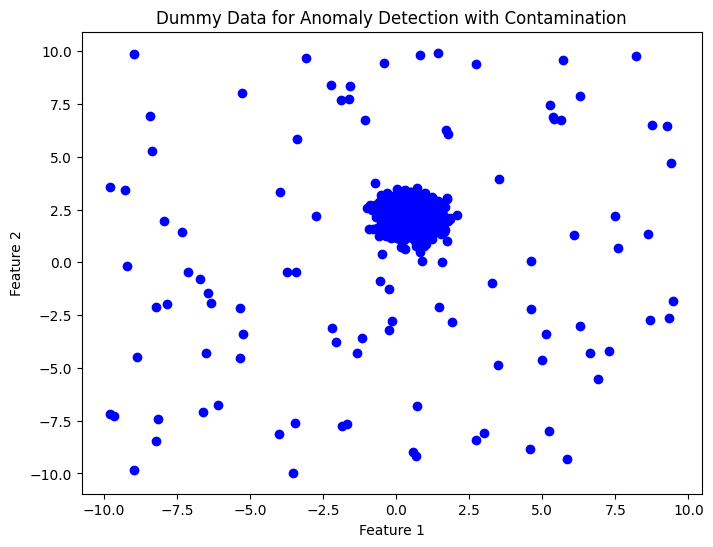

In [4]:
def generate_dummy_data(n_samples, contamination):
    # Generate normal data
    np.random.seed(0)
    normal_data, _ = make_blobs(n_samples=int(n_samples * (1 - contamination)), centers=1, cluster_std=0.5, center_box=(-5, 5))

    # Generate anomalies (contamination)
    anomaly_data= np.random.uniform(low=-10, high=10, size=(int(n_samples * contamination), 2))

    # Combine normal and anomaly data
    data = np.vstack([normal_data, anomaly_data])

    # Shuffle the data
    np.random.shuffle(data)
    
    return data

# Example usage
data = generate_dummy_data(n_samples=1000, contamination=0.1)

# Visualize the data
plt.figure(figsize=(8, 6))
plt.scatter(data[:, 0], data[:, 1], c='b')
plt.title('Dummy Data for Anomaly Detection with Contamination')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

In [5]:
df = pd.DataFrame(data, columns=['column1','column2'])
df.to_csv(input_file, index=False)

## Read data

In [6]:
print(input_file)
df = pd.read_csv(input_file)
print(df.shape)
print(df.columns)
df.head()

d:\E\Study\Projects\basicml\data\training\data.csv
(1000, 2)
Index(['column1', 'column2'], dtype='object')


,column1,column2
0,0.407448,3.049118
1,-0.318814,2.045524
2,0.092874,1.698244
3,-6.318686,-1.945856
4,-0.263063,1.263060


## Feature Engineering

## Hyperparameter tuning

Preparation

e^-(X^2) is a function which maps 

0 to 1

-inf to 0

+inf to 0

In [7]:
# understanding nearest neighbours distances
samples = [[0, 0],[1,1],[2,2]]
neigh = NearestNeighbors(n_neighbors=3)
neigh.fit(samples)
print(neigh.kneighbors([[0,2],[0,0]])[0])
np.min(neigh.kneighbors([[0,2],[0,0]])[0],axis=1)

[[1.41421356 2.         2.        ]
 [0.         1.41421356 2.82842712]]


array([1.41421356, 0.        ])

In [8]:
def calculate_avg_anomaly_score(model, df_anomaly):
    anomaly_scores = model.decision_function(df_anomaly.values)
    avg_anomaly_score = np.mean(anomaly_scores)
    return avg_anomaly_score

def calculate_separation_distances(df_to_fit, df_to_calculate):
    n_neighbors = 3
    result=0 if (len(df_to_fit)==0 or len(df_to_calculate)==0) else 1

    nbrs = NearestNeighbors(n_neighbors=n_neighbors, algorithm='ball_tree',n_jobs=-1).fit(df_to_fit.values)
    nbrs.kneighbors(df_to_calculate.values)
    distances = nbrs.kneighbors(df_to_calculate.values)[0]
    required_distances = np.min(distances, axis=1)
    result = np.mean(required_distances)
    return result

actual

First check if the range of parameters you are setting is right

NameError: name 'i' is not defined

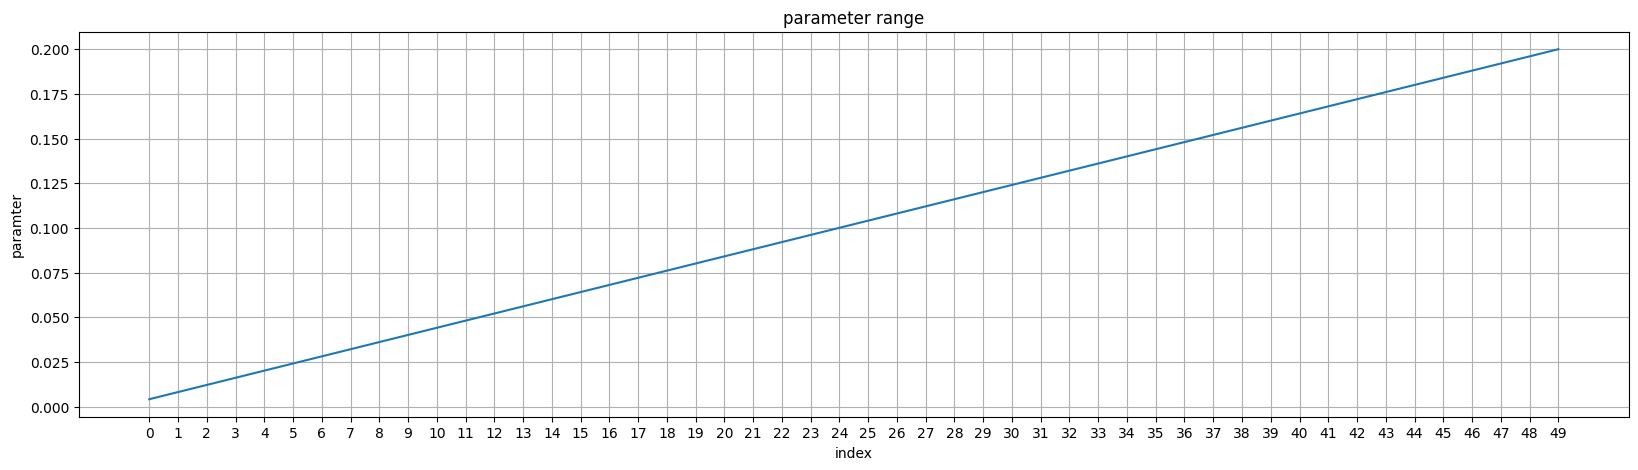

In [9]:
iterations = 5
main_start_point=0.0001
main_end_point=0.2
main_intervals=5
step=(main_end_point-main_start_point)/main_intervals
points_in_each_interval=10
small_step=step/points_in_each_interval
knee_points=[]
training_logs = {}

range_=[]

start_point=main_start_point
for _ in range(main_intervals):
    for _ in range(points_in_each_interval):
        #range_.append(random.uniform(start_point,start_point+step))
        range_.append(start_point+small_step)
        start_point=start_point+small_step

range_.sort()
plt.figure(figsize=(20,5))
plt.plot(range(len(range_)),range_)
plt.xlabel("index")
plt.ylabel("paramter")
plt.title("parameter range")
plt.xticks(range(len(range_)))
plt.grid()
plt.savefig(plots_path+"/training-parameter_generation.png"))
plt.show()
plt.close()

In [10]:
training_logs = {}

print("The big interval:"+"(",main_start_point,",",main_end_point,")")
print("step: ",step)
print("small step",small_step)

random_numbers = [1,1234,300]
for random_number in random_numbers:
    range_=[]
    print("random_number: ",random_number)
    start_point=main_start_point
    for _ in range(main_intervals):
        for _ in range(points_in_each_interval):
            #range_.append(random.uniform(start_point,start_point+step))
            range_.append(start_point+small_step)
            start_point=start_point+small_step

    range_.sort()
    neg_range_ = [-i for i in range_]
 
    separation_distances=[]
    for parameter in range_:
        model = IsolationForest(contamination=parameter,max_features=df.shape[1],max_samples=0.8, random_state=random_number)
        model.fit(df.values)
        outliers = model.predict(df.values)
        anomaly_indices = np.where(outliers == -1)[0]
        df_anomaly = df.iloc[anomaly_indices]
        df_nonanomaly = df.drop(anomaly_indices)
        separation_distances.append(calculate_separation_distances(df_to_fit=df_nonanomaly, df_to_calculate=df_anomaly))

    training_logs.update({"{}".format(random_number):
                    {
                    'range_':range_,
                    'neg_range_': neg_range_,
                    'scores': separation_distances                   
                    }})

The big interval:( 0.0001 , 0.2 )
step:  0.03998
small step 0.003998
random_number:  1
random_number:  1234
random_number:  300


## Dump training logs

In [13]:
# all in one
with open(training_logs_file, 'w') as f:
    json.dump(training_logs, f)

In [27]:
# Each iteration separately
for i in random_numbers:
    range_ = training_logs.get("{}".format(i)).get("range_")
    neg_range = [-i for i in range_]
    scores = training_logs.get("{}".format(i)).get("scores")
    pd.DataFrame({
        'parameter':range_,
        'scores':scores      
        }).to_csv(training_data_path+"/random_number-{}.csv".format(i),index=False)

In [15]:
training_data_path

'd:\\E\\Study\\Projects\\basicml\\data\\training'

## Read training logs

In [16]:
with open(training_logs_file, 'r') as f:
    training_logs = json.load(f)

## Visualize training logs

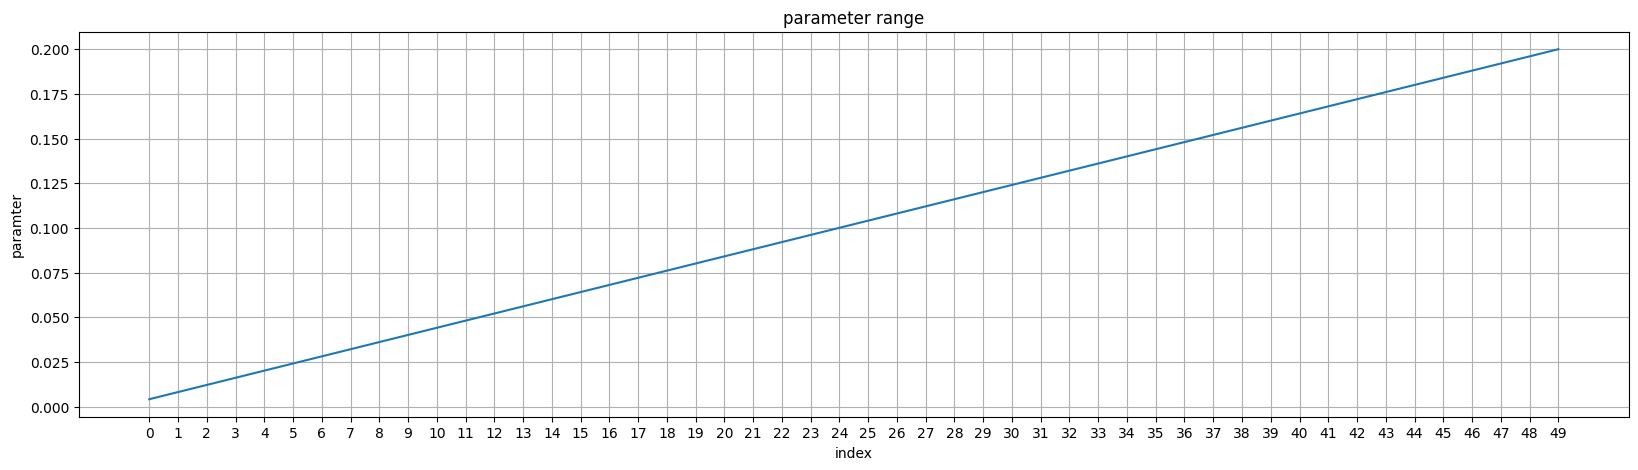

In [17]:
for i in [random_numbers[0]]:
    range_ = training_logs.get("{}".format(i)).get("range_")
    neg_range = [-i for i in range_]
    avg_anomaly_scores = training_logs.get("{}".format(i)).get("avg_anomaly_scores")
    plt.figure(figsize=(20,5))
    plt.plot(range(len(range_)),range_)
    plt.xlabel("index")
    plt.ylabel("paramter")
    plt.title("parameter range")
    plt.xticks(range(len(range_)))
    plt.grid()
    plt.savefig(plots_path+"/training-parameter_generation.png")
    plt.show()
    plt.close()


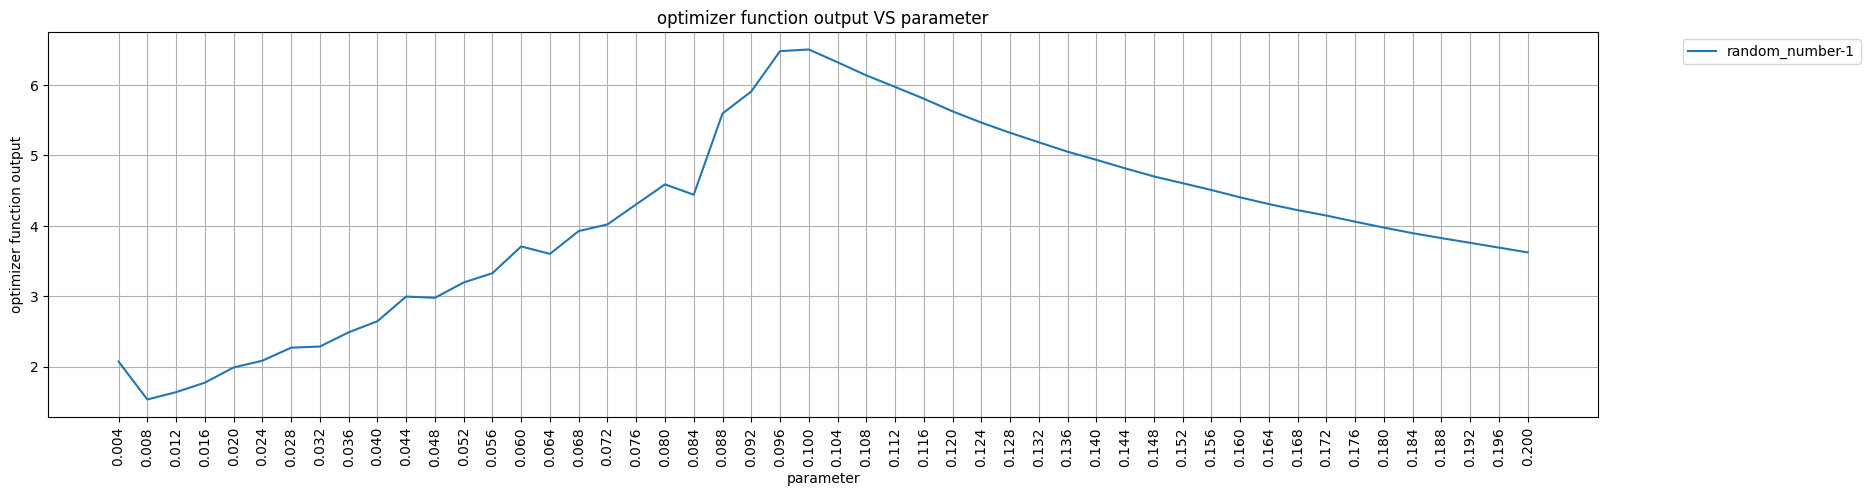

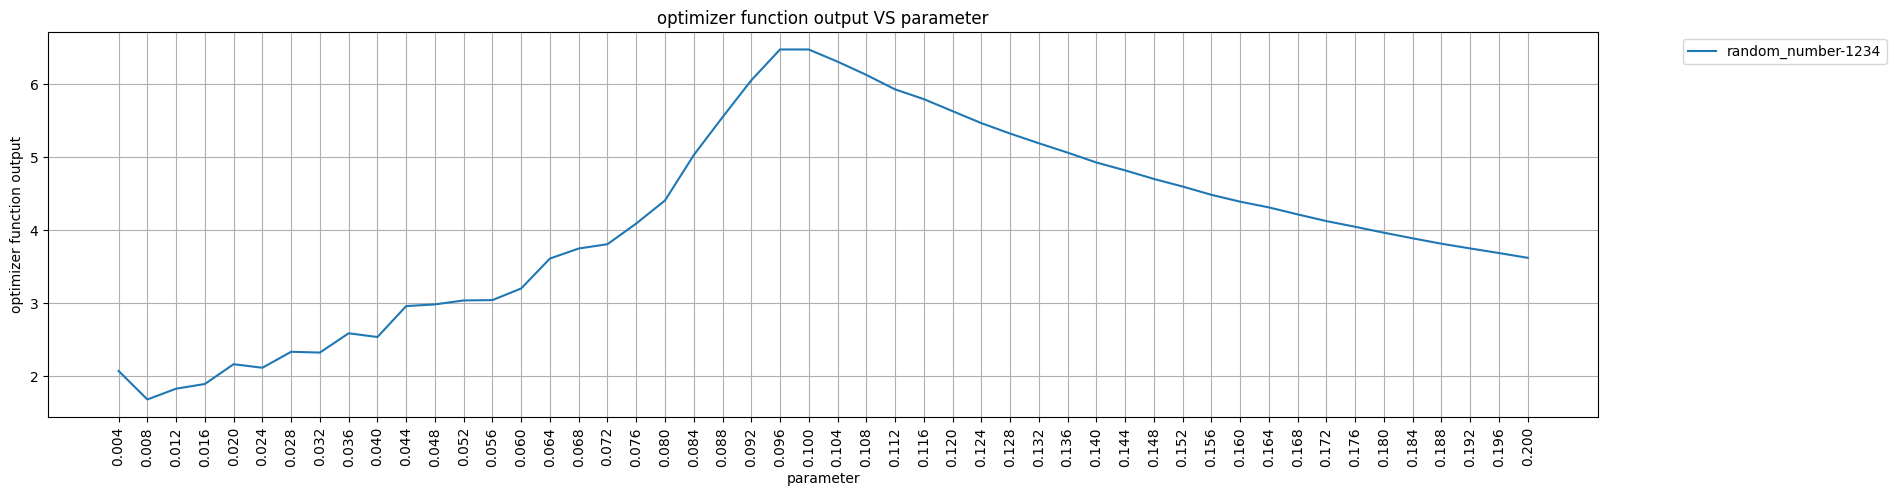

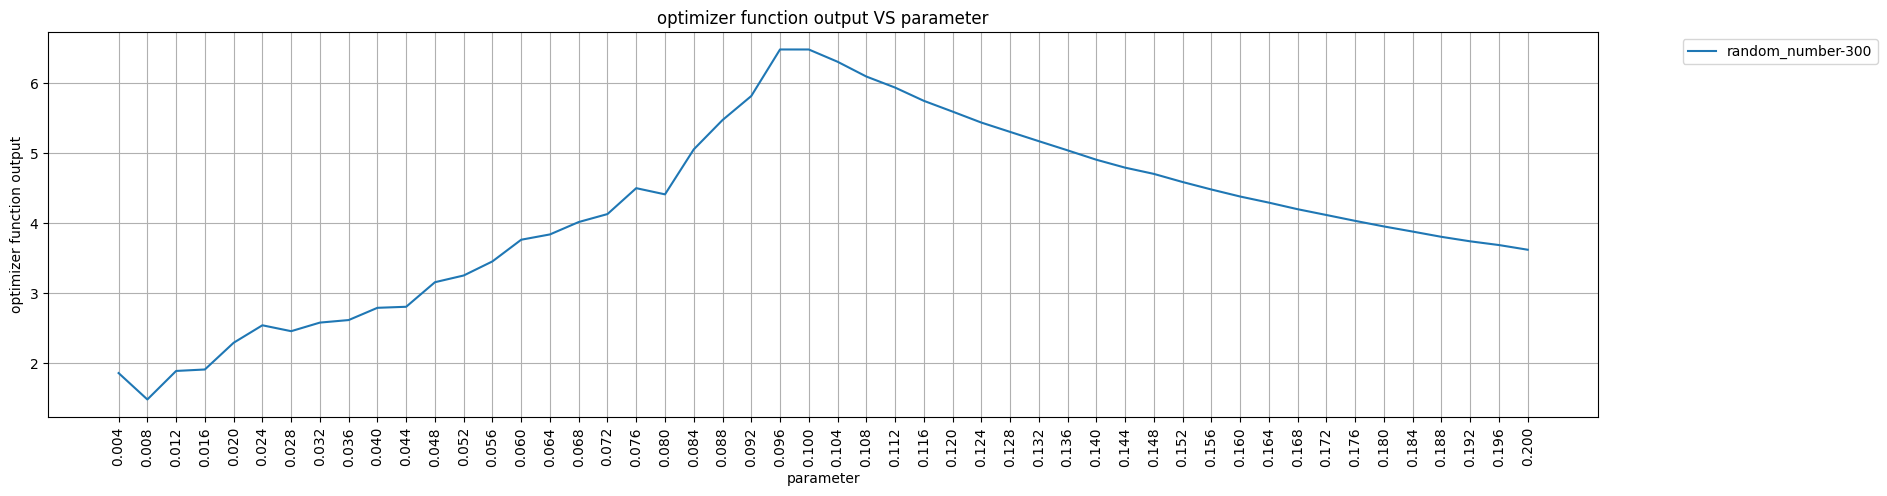

In [18]:
for i in random_numbers:
    range_ = training_logs.get("{}".format(i)).get("range_")
    scores = training_logs.get("{}".format(i)).get("scores")
    plt.figure(figsize=(20,5))
    plt.plot(range_,scores,label="random_number-{}".format(i))
    plt.xlabel("parameter")
    plt.ylabel("optimizer function output")
    plt.title("optimizer function output VS parameter")
    plt.xticks(range_, rotation='vertical')
    plt.grid()
    plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
    plt.savefig(plots_path+"/training-parameter_and_output-iteration-{}.png".format(i))
    plt.show()
    plt.close()

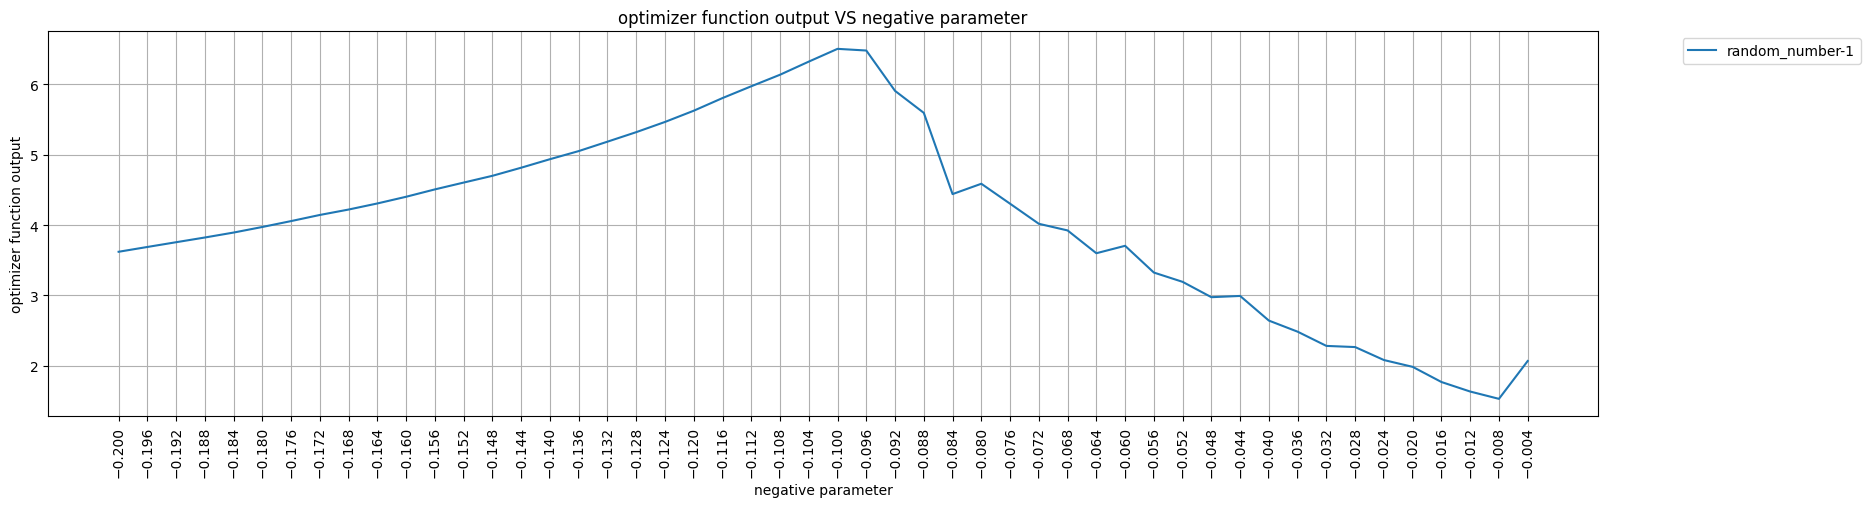

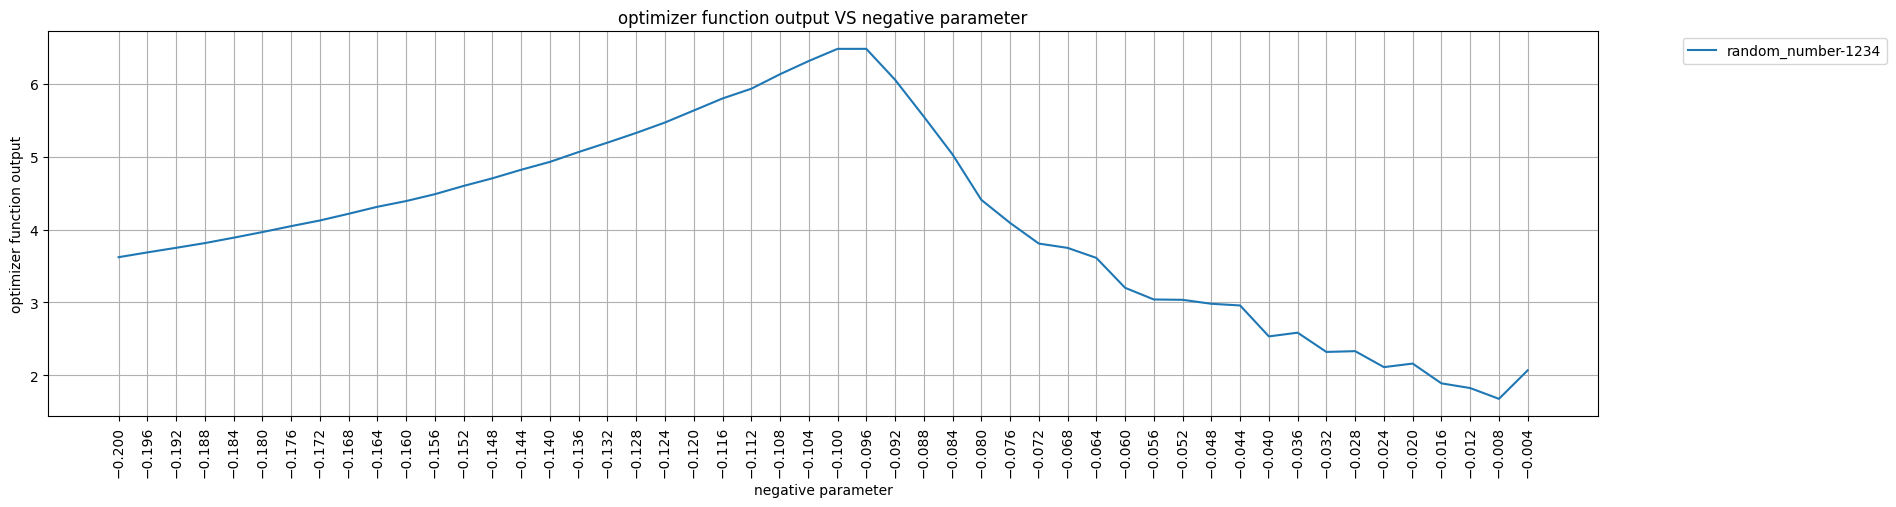

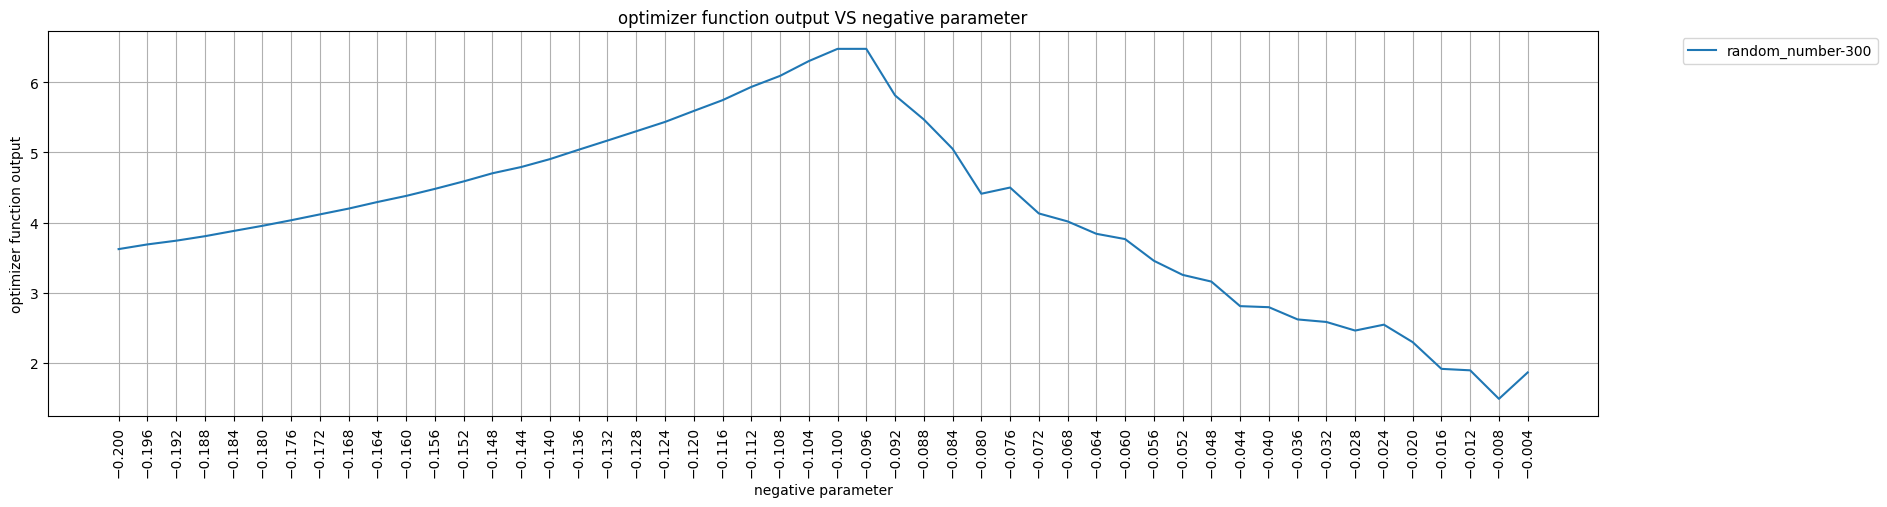

In [19]:
for i in random_numbers:
    range_ = training_logs.get("{}".format(i)).get("range_")
    neg_range = [-i for i in range_]
    scores = training_logs.get("{}".format(i)).get("scores")
    plt.figure(figsize=(20,5))
    plt.plot(neg_range,scores,label="random_number-{}".format(i))
    plt.xlabel("negative parameter")
    plt.ylabel("optimizer function output")
    plt.title("optimizer function output VS negative parameter")
    plt.xticks(neg_range,rotation='vertical')
    plt.grid()
    plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
    plt.savefig(plots_path+"/negative_training-parameter_and_output-iteration-{}.png".format(i))
    plt.show()
    plt.close()

## Get the best parameter

In [20]:
knee_points=[]
for i in random_numbers:
    range_ = training_logs.get("{}".format(i)).get("range_")
    scores = training_logs.get("{}".format(i)).get("scores")
    knee_locator = KneeLocator(range_, scores, curve='concave', direction='increasing')
    knee_point = knee_locator.knee
    knee_point = None if knee_point==None else knee_point
    knee_points.append(knee_point)

In [21]:
print(knee_points)
while None in knee_points:
    knee_points.remove(None)
print(knee_points)
final_optimized_parameter = np.mean(knee_points)
print(final_optimized_parameter)

[0.004098, 0.004098, 0.004098]
[0.004098, 0.004098, 0.004098]
0.004098


In [22]:
print("The final_optimized_parameter chosen by algorithm: ",final_optimized_parameter)
print("Please note that there is no guarantee that the above value is the best.")
print("Please view plots and training logs to select the best value for the parameter")
final_optimized_parameter = input("Please enter the parameter value for the final ML model: ")
final_optimized_parameter = float(final_optimized_parameter)

The final_optimized_parameter chosen by algorithm:  0.004098
Please note that there is no guarantee that the above value is the best.
Please view plots and training logs to select the best value for the parameter


## Final model

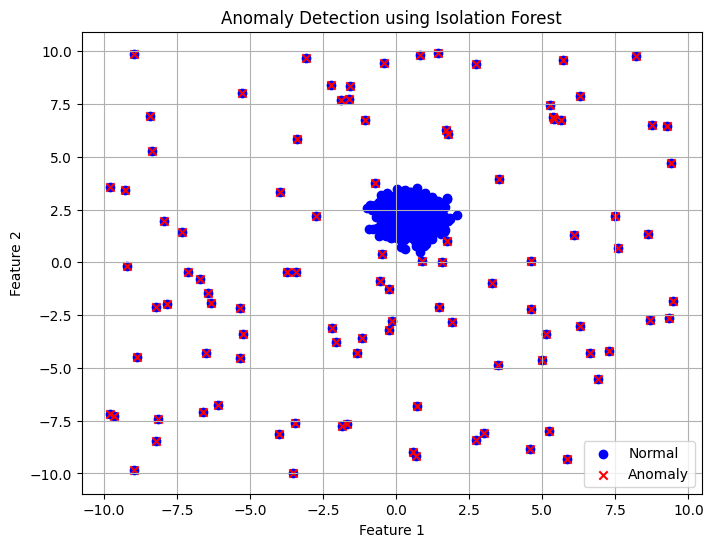

In [28]:
# Create and fit the Isolation Forest model
model = IsolationForest(contamination=final_optimized_parameter,max_features=df.shape[1])
model.fit(df.values)

# Predict outliers/anomalies
outliers = model.predict(df.values)

# Anomalies will be labeled as -1, normal points as 1
anomaly_indices = np.where(outliers == -1)[0]

# Visualize the data with anomalies highlighted
plt.figure(figsize=(8, 6))
plt.scatter(df.iloc[:, 0],df.iloc[:, 1], c='b', marker='o', label='Normal')
plt.scatter(df.iloc[anomaly_indices, 0], df.iloc[anomaly_indices, 1], c='r', marker='x', label='Anomaly')
plt.title('Anomaly Detection using Isolation Forest')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True)
plt.show()

## Save model

In [24]:
import pickle

with open('./../../resources/model.pkl', 'wb') as f:
    pickle.dump(model, f)

## Inference

In [25]:
#inference
given_point = [4,-4]
given_point = [np.array(given_point)]
model.predict(given_point)[0]

-1